# Retail Product Recommendation with Negative Implicit Feedback
> A tutorial to demonstrate the process of training and evaluating various recommender models on a online retail store data. Along with the positive feedbacks like view, add-to-cart, we also have a negative event 'remove-from-cart'.

- toc: true
- badges: true
- comments: true
- categories: [retail]
- image: 

In [2]:
#hide
!pip install git+https://github.com/maciejkula/spotlight.git@master#egg=spotlight
!git clone https://github.com/microsoft/recommenders.git
!pip install cornac
!pip install pandas==0.25.0

  Cloning https://github.com/maciejkula/spotlight.git (to revision master) to /tmp/pip-install-lriz796i/spotlight
  Running command git clone -q https://github.com/maciejkula/spotlight.git /tmp/pip-install-lriz796i/spotlight
  Created wheel for spotlight: filename=spotlight-0.1.6-cp37-none-any.whl size=33921 sha256=14d494182314d40e31c6caabd4cc6723fa7bc9428606a9a11882e6bce2ece08f
  Stored in directory: /tmp/pip-ephem-wheel-cache-jxgos5jf/wheels/de/0f/85/71b17c59d32cb9d29c31d4ffb16eb14f4cc153f1e28c7a3efb
Successfully built spotlight
Cloning into 'recommenders'...
remote: Enumerating objects: 25279, done.
remote: Counting objects: 100% (286/286), done.
remote: Compressing objects: 100% (231/231), done.
remote: Total 25279 (delta 115), reused 152 (delta 53), pack-reused 24993
Receiving objects: 100% (25279/25279), 197.06 MiB | 27.41 MiB/s, done.
Resolving deltas: 100% (16508/16508), done.
     |████████████████████████████████| 13.4MB 323kB/s 
     |████████████████████████████████| 10.4MB

In [1]:
#hide
import os
import sys
import math
import random
import datetime
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from scipy.sparse import csr_matrix, dok_matrix
from sklearn.model_selection import ParameterGrid

from fastai.collab import *
from fastai.tabular import *
from fastai.text import *

import cornac

from spotlight.interactions import Interactions
from spotlight.interactions import SequenceInteractions
from spotlight.cross_validation import random_train_test_split
from spotlight.cross_validation import user_based_train_test_split
from spotlight.factorization.implicit import ImplicitFactorizationModel
from spotlight.evaluation import mrr_score
from spotlight.evaluation import precision_recall_score

from spotlight.interactions import Interactions
from spotlight.cross_validation import random_train_test_split
from spotlight.cross_validation import user_based_train_test_split
from spotlight.factorization.implicit import ImplicitFactorizationModel
from spotlight.evaluation import mrr_score
from spotlight.evaluation import precision_recall_score

from spotlight.interactions import SequenceInteractions
from spotlight.sequence.implicit import ImplicitSequenceModel
from spotlight.evaluation import sequence_mrr_score
from spotlight.evaluation import sequence_precision_recall_score

import warnings
warnings.filterwarnings("ignore")

In [4]:
#hide
sys.path.append('/content/recommenders/')
from reco_utils.dataset.python_splitters import python_chrono_split
from reco_utils.evaluation.python_evaluation import map_at_k
from reco_utils.evaluation.python_evaluation import precision_at_k
from reco_utils.evaluation.python_evaluation import ndcg_at_k 
from reco_utils.evaluation.python_evaluation import recall_at_k
from reco_utils.evaluation.python_evaluation import get_top_k_items
from reco_utils.recommender.cornac.cornac_utils import predict_ranking

## Data Loading

In [5]:
# loading data
df = pd.read_csv('rawdata.csv', header = 0,
                 names = ['event','userid','itemid','timestamp'],
                 dtype={0:'category', 1:'category', 2:'category'},
                 parse_dates=['timestamp'])

In [6]:
df.head()

,event,userid,itemid,timestamp
0,view_item,2763227,11056,2020-01-13 16:05:31.244000+00:00
1,add_to_cart,2828666,14441,2020-01-13 22:36:38.680000+00:00
2,view_item,0620225789,14377,2020-01-14 10:54:41.886000+00:00
3,view_item,0620225789,14377,2020-01-14 10:54:47.692000+00:00
4,add_to_cart,0620225789,14377,2020-01-14 10:54:48.479000+00:00


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99998 entries, 0 to 99997
Data columns (total 4 columns):
event        99998 non-null category
userid       99998 non-null category
itemid       99998 non-null category
timestamp    99998 non-null datetime64[ns, UTC]
dtypes: category(3), datetime64[ns, UTC](1)
memory usage: 1.7 MB


## Wrangling

### Removing Duplicates

In [8]:
# dropping exact duplicates
df = df.drop_duplicates()

### Label Encoding

In [9]:
# userid normalization
userid_encoder = preprocessing.LabelEncoder()
df.userid = userid_encoder.fit_transform(df.userid)

# itemid normalization
itemid_encoder = preprocessing.LabelEncoder()
df.itemid = itemid_encoder.fit_transform(df.itemid)

## Exploration

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
userid,99432.0,4682.814677,3011.178734,0.0,2507.0,3687.0,6866.0,11476.0
itemid,99432.0,1344.579964,769.627122,0.0,643.0,1356.0,1997.0,2633.0


In [11]:
df.describe(exclude='int').T

,count,unique,top,freq,first,last
event,99432,5,begin_checkout,41459,NaT,NaT
timestamp,99432,61372,2020-01-16 04:21:49.377000+00:00,25,2020-01-13 16:05:31.244000+00:00,2020-03-10 13:02:21.376000+00:00


In [12]:
df.timestamp.max() - df.timestamp.min()

Timedelta('56 days 20:56:50.132000')

In [13]:
df.event.value_counts()

begin_checkout      41459
view_item           35397
purchase             9969
add_to_cart          7745
remove_from_cart     4862
Name: event, dtype: int64

In [14]:
df.event.value_counts()/df.userid.nunique()

begin_checkout      3.612355
view_item           3.084168
purchase            0.868607
add_to_cart         0.674828
remove_from_cart    0.423630
Name: event, dtype: float64

### User Interactions

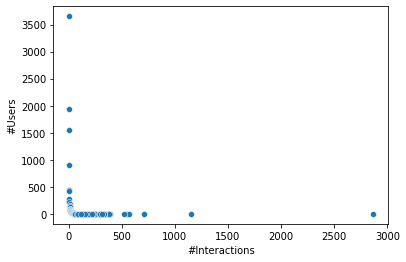

In [15]:
#hide-input
# User events
user_activity_count = dict()
for row in df.itertuples():
    if row.userid not in user_activity_count:
        user_activity_count[row.userid] = {'view_item':0, 
                                           'add_to_cart':0,
                                           'begin_checkout':0,
                                           'remove_from_cart':0, 
                                           'purchase':0}
    if row.event == 'view_item':
        user_activity_count[row.userid]['view_item'] += 1
    elif row.event == 'add_to_cart':
        user_activity_count[row.userid]['add_to_cart'] += 1
    elif row.event == 'begin_checkout':
        user_activity_count[row.userid]['begin_checkout'] += 1
    elif row.event == 'remove_from_cart':
        user_activity_count[row.userid]['remove_from_cart'] += 1
    elif row.event == 'purchase':
        user_activity_count[row.userid]['purchase'] += 1

user_activity = pd.DataFrame(user_activity_count)
user_activity = user_activity.transpose()
user_activity['activity'] = user_activity.sum(axis=1)

tempDF = pd.DataFrame(user_activity.activity.value_counts()).reset_index()
tempDF.columns = ['#Interactions','#Users']
sns.scatterplot(x='#Interactions', y='#Users', data=tempDF);

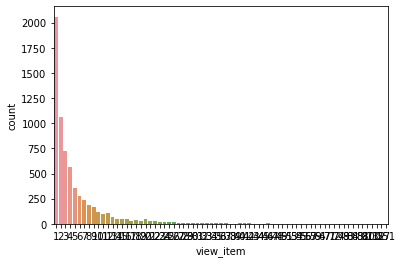

In [16]:
#hide
df_activity = user_activity.copy()
event = df_activity.columns.astype('str')
sns.countplot(df_activity.loc[df_activity[event[0]]>0,event[0]]);

### Add-to-cart Event Counts

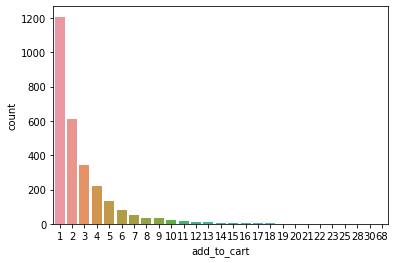

In [17]:
#hide-input
sns.countplot(df_activity.loc[df_activity[event[1]]>0,event[1]])
plt.show()

### Purchase Event Counts

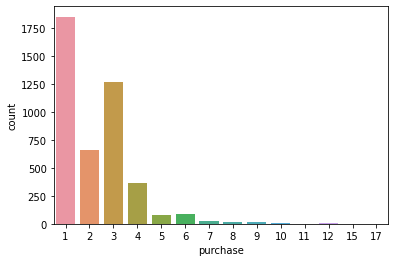

In [18]:
#hide-input
sns.countplot(df_activity.loc[df_activity[event[4]]>0,event[4]])
plt.show()

### Item Interactions

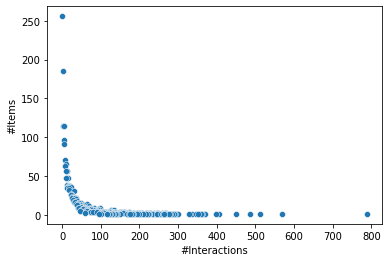

In [19]:
#hide-input
# item events
item_activity_count = dict()
for row in df.itertuples():
    if row.itemid not in item_activity_count:
        item_activity_count[row.itemid] = {'view_item':0, 
                                           'add_to_cart':0,
                                           'begin_checkout':0,
                                           'remove_from_cart':0, 
                                           'purchase':0}
    if row.event == 'view_item':
        item_activity_count[row.itemid]['view_item'] += 1
    elif row.event == 'add_to_cart':
        item_activity_count[row.itemid]['add_to_cart'] += 1
    elif row.event == 'begin_checkout':
        item_activity_count[row.itemid]['begin_checkout'] += 1
    elif row.event == 'remove_from_cart':
        item_activity_count[row.itemid]['remove_from_cart'] += 1
    elif row.event == 'purchase':
        item_activity_count[row.itemid]['purchase'] += 1

item_activity = pd.DataFrame(item_activity_count)
item_activity = item_activity.transpose()
item_activity['activity'] = item_activity.sum(axis=1)

tempDF = pd.DataFrame(item_activity.activity.value_counts()).reset_index()
tempDF.columns = ['#Interactions','#Items']
sns.scatterplot(x='#Interactions', y='#Items', data=tempDF);

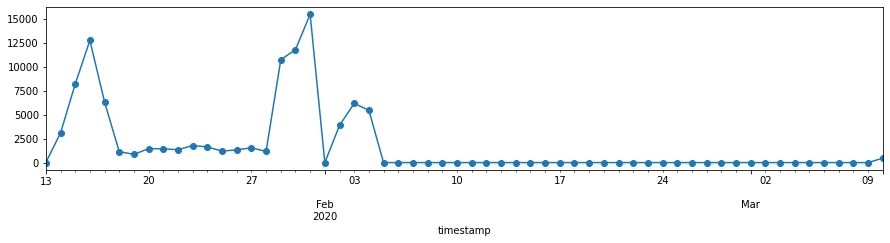

In [20]:
#hide
plt.rcParams['figure.figsize'] = 15,3
data = pd.DataFrame(pd.to_datetime(df['timestamp'], infer_datetime_format=True))
data['Count'] = 1
data.set_index('timestamp', inplace=True)
data = data.resample('D').apply({'Count':'count'})
ax = data['Count'].plot(marker='o', linestyle='-')

## Rule-based Approaches

### Top-N Trending Products

In [21]:
#collapse
def top_trending(n, timeperiod, timestamp):
  start = str(timestamp.replace(microsecond=0) - pd.Timedelta(minutes=timeperiod))
  end = str(timestamp.replace(microsecond=0))
  trending_items = df.loc[(df.timestamp.between(start,end) & (df.event=='view_item')),:].sort_values('timestamp', ascending=False)
  return trending_items.itemid.value_counts().index[:n]

In [27]:
user_current_time = df.timestamp[100]
top_trending(5, 50, user_current_time)

Int64Index([2241, 972, 393, 1118, 126], dtype='int64')

### Top-N Least Viewed Items

In [28]:
#collapse
def least_n_items(n=10):
  temp1 = df.loc[df.event=='view_item'].groupby(['itemid'])['event'].count().sort_values(ascending=True).reset_index()
  temp2 = df.groupby('itemid').timestamp.max().reset_index()
  item_ids = pd.merge(temp1,temp2,on='itemid').sort_values(['event', 'timestamp'], ascending=[True, False]).reset_index().loc[:n-1,'itemid']
  return itemid_encoder.inverse_transform(item_ids.values)

In [29]:
least_n_items(10)

array(['15742', '16052', '16443', '16074', '16424', '11574', '11465', '16033', '11711', '16013'], dtype=object)

# Data Transformation

Many times there are no explicit ratings or preferences given by users, that is, the interactions are usually implicit. This
information may reflect users' preference towards the items in an implicit manner.

Option 1 - Simple Count: The most simple technique is to count times of interactions between user and item for
producing affinity scores.

Option 2 - Weighted Count: It is useful to consider the types of different interactions as weights in the count
aggregation. For example, assuming weights of the three differen types, "click", "add", and "purchase", are 1, 2, and 3, respectively.

Option 3 - Time-dependent Count: In many scenarios, time dependency plays a critical role in preparing dataset for
building a collaborative filtering model that captures user interests drift over time. One of the common techniques for
achieving time dependent count is to add a time decay factor in the counting.


### A. Count

In [30]:
#collapse
data_count = df.groupby(['userid', 'itemid']).agg({'timestamp': 'count'}).reset_index()
data_count.columns = ['userid', 'itemid', 'affinity']
data_count.head()

,userid,itemid,affinity
0,0,328,1
1,1,1122,1
2,1,1204,1
3,1,1271,1
4,1,1821,1


### B. Weighted Count

In [34]:
#hide
data_w = df.loc[df.event!='remove_from_cart',:]

affinity_weights = {
    'view_item': 1,
    'add_to_cart': 3, 
    'begin_checkout': 5, 
    'purchase': 6,
    'remove_from_cart': 3
}

data_w['event'].apply(lambda x: affinity_weights[x])

data_w.head()

,event,userid,itemid,timestamp
0,view_item,3141,236,2020-01-13 16:05:31.244000+00:00
1,add_to_cart,3421,1001,2020-01-13 22:36:38.680000+00:00
2,view_item,550,972,2020-01-14 10:54:41.886000+00:00
3,view_item,550,972,2020-01-14 10:54:47.692000+00:00
4,add_to_cart,550,972,2020-01-14 10:54:48.479000+00:00


In [36]:
#collapse
data_w['weight'] = data_w['event'].apply(lambda x: affinity_weights[x])
data_wcount = data_w.groupby(['userid', 'itemid'])['weight'].sum().reset_index()
data_wcount.columns = ['userid', 'itemid', 'affinity']
data_wcount.head()

,userid,itemid,affinity
0,0,328,6
1,1,1122,6
2,1,1204,6
3,1,1271,6
4,1,1821,6


### C. Time dependent Count

In [39]:
#hide
T = 30
t_ref = datetime.datetime.utcnow()

data_w['timedecay'] = data_w.apply(
    lambda x: x['weight'] * math.exp(-math.log2((t_ref - pd.to_datetime(x['timestamp']).tz_convert(None)).days / T)), 
    axis=1
)

data_w.head()

,event,userid,itemid,timestamp,weight,timedecay
0,view_item,3141,236,2020-01-13 16:05:31.244000+00:00,1,0.019056
1,add_to_cart,3421,1001,2020-01-13 22:36:38.680000+00:00,3,0.057167
2,view_item,550,972,2020-01-14 10:54:41.886000+00:00,1,0.019056
3,view_item,550,972,2020-01-14 10:54:47.692000+00:00,1,0.019056
4,add_to_cart,550,972,2020-01-14 10:54:48.479000+00:00,3,0.057167


In [40]:
#collapse
data_wt = data_w.groupby(['userid', 'itemid'])['timedecay'].sum().reset_index()
data_wt.columns = ['userid', 'itemid', 'affinity']
data_wt.head()

,userid,itemid,affinity
0,0,328,0.117590
1,1,1122,0.120232
2,1,1204,0.120232
3,1,1271,0.120232
4,1,1821,0.120232


# Train Test Split

Option 1 - Random Split: Random split simply takes in a data set and outputs the splits of the data, given the split
ratios

Option 2 - Chronological split: Chronogically splitting method takes in a dataset and splits it on timestamp


In [41]:
#collapse
data = data_w[['userid','itemid','timedecay','timestamp']]

col = {
  'col_user': 'userid',
  'col_item': 'itemid',
  'col_rating': 'timedecay',
  'col_timestamp': 'timestamp',
}

col3 = {
  'col_user': 'userid',
  'col_item': 'itemid',
  'col_timestamp': 'timestamp',
}

train, test = python_chrono_split(data, ratio=0.75, min_rating=10, 
                                  filter_by='user', **col3)

In [44]:
train.loc[train.userid==7,:]

,userid,itemid,timedecay,timestamp
16679,7,1464,0.019174,2020-01-16 06:42:31.341000+00:00
16691,7,1464,0.019174,2020-01-16 06:43:29.482000+00:00
16692,7,2109,0.019174,2020-01-16 06:43:42.262000+00:00
16694,7,1464,0.019174,2020-01-16 06:43:57.961000+00:00
16805,7,201,0.019174,2020-01-16 06:45:55.261000+00:00
16890,7,2570,0.019174,2020-01-16 06:54:12.315000+00:00
16999,7,2570,0.019174,2020-01-16 06:54:29.130000+00:00
17000,7,2570,0.057522,2020-01-16 06:54:35.097000+00:00


In [45]:
test.loc[test.userid==7,:]

,userid,itemid,timedecay,timestamp
17001,7,1464,0.019174,2020-01-16 06:54:41.415000+00:00
17003,7,1464,0.057522,2020-01-16 06:54:44.195000+00:00


# Experiments

### Item Popularity Recomendation Model

In [46]:
#hide
# Recommending the most popular items is intuitive and simple approach
item_counts = train['itemid'].value_counts().to_frame().reset_index()
item_counts.columns = ['itemid', 'count']
item_counts.head()

,itemid,count
0,2564,461
1,1463,302
2,1710,267
3,1985,243
4,886,229


In [47]:
#hide
user_item_col = ['userid', 'itemid']

# Cross join users and items
test_users = test['userid'].unique()
user_item_list = list(itertools.product(test_users, item_counts['itemid']))
users_items = pd.DataFrame(user_item_list, columns=user_item_col)

print("Number of user-item pairs:", len(users_items))

# Remove seen items (items in the train set) as we will not recommend those again to the users
from reco_utils.dataset.pandas_df_utils import filter_by
users_items_remove_seen = filter_by(users_items, train, user_item_col)

print("After remove seen items:", len(users_items_remove_seen))

Number of user-item pairs: 4124250
After remove seen items: 4107466


In [48]:
# Generate recommendations
baseline_recommendations = pd.merge(item_counts, users_items_remove_seen, 
                                    on=['itemid'], how='inner')
baseline_recommendations.head()

,itemid,count,userid
0,2564,461,7
1,2564,461,21
2,2564,461,73
3,2564,461,75
4,2564,461,113


In [ ]:
#hide
k = 10

cols = {
  'col_user': 'userid',
  'col_item': 'itemid',
  'col_rating': 'timedecay',
  'col_prediction': 'count',
}

eval_map = map_at_k(test, baseline_recommendations, k=k, **cols)
eval_ndcg = ndcg_at_k(test, baseline_recommendations, k=k, **cols)
eval_precision = precision_at_k(test, baseline_recommendations, k=k, **cols)
eval_recall = recall_at_k(test, baseline_recommendations, k=k, **cols)

In [49]:
print("MAP:\t%f" % eval_map,
      "NDCG@K:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

MAP:	0.005334
NDCG@K:	0.010356
Precision@K:	0.007092
Recall@K:	0.011395


### Cornac BPR Model

In [53]:
#hide
TOP_K = 10
NUM_FACTORS = 200
NUM_EPOCHS = 100
SEED = 40

train_set = cornac.data.Dataset.from_uir(train.itertuples(index=False), seed=SEED)

bpr = cornac.models.BPR(
    k=NUM_FACTORS,
    max_iter=NUM_EPOCHS,
    learning_rate=0.01,
    lambda_reg=0.001,
    verbose=True,
    seed=SEED
)

from reco_utils.common.timer import Timer
with Timer() as t:
    bpr.fit(train_set)
print("Took {} seconds for training.".format(t))


Optimization finished!
Took 3.1812 seconds for training.


In [54]:
#hide
with Timer() as t:
    all_predictions = predict_ranking(bpr, train, usercol='userid', itemcol='itemid', remove_seen=True)
print("Took {} seconds for prediction.".format(t))

Took 4.7581 seconds for prediction.


In [55]:
all_predictions.head()

,userid,itemid,prediction
51214,7,2551,-0.438445
51215,7,481,2.522187
51216,7,1185,2.406107
51217,7,1766,1.112975
51218,7,1359,2.083620


In [ ]:
#hide
k = 10
cols = {
  'col_user': 'userid',
  'col_item': 'itemid',
  'col_rating': 'timedecay',
  'col_prediction': 'prediction',
}

eval_map = map_at_k(test, all_predictions, k=k, **cols)
eval_ndcg = ndcg_at_k(test, all_predictions, k=k, **cols)
eval_precision = precision_at_k(test, all_predictions, k=k, **cols)
eval_recall = recall_at_k(test, all_predictions, k=k, **cols)

In [ ]:
#hide-input
print("MAP:\t%f" % eval_map,
      "NDCG:\t%f" % eval_ndcg,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

MAP:	0.004738
NDCG:	0.009597
Precision@K:	0.006601
Recall@K:	0.010597


### SARS Model

In [ ]:
#collapse
from reco_utils.recommender.sar.sar_singlenode import SARSingleNode

TOP_K = 10

header = {
    "col_user": "userid",
    "col_item": "itemid",
    "col_rating": "timedecay",
    "col_timestamp": "timestamp",
    "col_prediction": "prediction",
}

model = SARSingleNode(
    similarity_type="jaccard", 
    time_decay_coefficient=0, 
    time_now=None, 
    timedecay_formula=False, 
    **header
)

model.fit(train)

In [ ]:
#hide
top_k = model.recommend_k_items(test, remove_seen=True)

# all ranking metrics have the same arguments
args = [test, top_k]
kwargs = dict(col_user='userid', 
              col_item='itemid', 
              col_rating='timedecay', 
              col_prediction='prediction', 
              relevancy_method='top_k', 
              k=TOP_K)

eval_map = map_at_k(*args, **kwargs)
eval_ndcg = ndcg_at_k(*args, **kwargs)
eval_precision = precision_at_k(*args, **kwargs)
eval_recall = recall_at_k(*args, **kwargs)

In [ ]:
#hide-input
print(f"Model:",
      f"Top K:\t\t {TOP_K}",
      f"MAP:\t\t {eval_map:f}",
      f"NDCG:\t\t {eval_ndcg:f}",
      f"Precision@K:\t {eval_precision:f}",
      f"Recall@K:\t {eval_recall:f}", sep='\n')

Model:
Top K:		 10
MAP:		 0.024426
NDCG:		 0.032738
Precision@K:	 0.019258
Recall@K:	 0.036009


### Spotlight


#### Implicit Factorization Model

In [ ]:
#collapse
interactions = Interactions(user_ids = df.userid.astype('int32').values,
                            item_ids = df.itemid.astype('int32').values,
                            timestamps = df.timestamp.astype('int32'),
                            num_users = df.userid.nunique(),
                            num_items = df.itemid.nunique())

train_user, test_user = random_train_test_split(interactions, test_percentage=0.2)

model = ImplicitFactorizationModel(loss='bpr', embedding_dim=64, n_iter=10, 
                                   batch_size=256, l2=0.0, learning_rate=0.01, 
                                   optimizer_func=None, use_cuda=False, 
                                   representation=None, sparse=False, 
                                   num_negative_samples=10)

model.fit(train_user, verbose=1)

pr = precision_recall_score(model, test=test_user, train=train_user, k=10)
print('Pricison@10 is {:.3f} and Recall@10 is {:.3f}'.format(pr[0].mean(), pr[1].mean()))

Epoch 0: loss 0.26659833122392174
Epoch 1: loss 0.06129162273462562
Epoch 2: loss 0.022607273167640066
Epoch 3: loss 0.013953083943443858
Epoch 4: loss 0.01050195922488137
Epoch 5: loss 0.009170394043447121
Epoch 6: loss 0.008144461540834697
Epoch 7: loss 0.007209992620171649
Epoch 8: loss 0.00663076309035038
Epoch 9: loss 0.006706491189820159
Pricison@10 is 0.007 and Recall@10 is 0.050


Implicit Factorization Model with Grid Search

In [ ]:
#hide
interactions = Interactions(user_ids = df.userid.astype('int32').values,
                            item_ids = df.itemid.astype('int32').values,
                            timestamps = df.timestamp.astype('int32'),
                            num_users = df.userid.nunique(),
                            num_items = df.itemid.nunique())

train_user, test_user = random_train_test_split(interactions, test_percentage=0.2)

params_grid = {'loss':['bpr', 'hinge'],
               'embedding_dim':[32, 64],
               'learning_rate': [0.01, 0.05, 0.1],
               'num_negative_samples': [5,10,50]
               }
grid = ParameterGrid(params_grid)

for p in grid:
  model = ImplicitFactorizationModel(**p, n_iter=10, batch_size=256, l2=0.0, 
                                    optimizer_func=None, use_cuda=False, 
                                    representation=None, sparse=False)
  model.fit(train_user, verbose=1)
  pr = precision_recall_score(model, test=test_user, train=train_user, k=10)
  print('Pricison@10 is {:.3f} and Recall@10 is {:.3f}'.format(pr[0].mean(), pr[1].mean()))

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:1139: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]


Epoch 0: loss 0.29605319564173843
Epoch 1: loss 0.09024034632172231
Epoch 2: loss 0.04134876810469428
Epoch 3: loss 0.025742946812505697
Epoch 4: loss 0.019680531030682506
Epoch 5: loss 0.016188400935297803
Epoch 6: loss 0.013594527123945127
Epoch 7: loss 0.012133106459800596
Epoch 8: loss 0.011063214711144184
Epoch 9: loss 0.010611439098295579
Pricison@10 is 0.007 and Recall@10 is 0.047
Epoch 0: loss 0.29609743690184076
Epoch 1: loss 0.09252797421726766
Epoch 2: loss 0.04244603450826318
Epoch 3: loss 0.02713844289709709
Epoch 4: loss 0.01969600333667501
Epoch 5: loss 0.01603335079847808
Epoch 6: loss 0.014221997893418386
Epoch 7: loss 0.012988711276070673
Epoch 8: loss 0.011557109632238842
Epoch 9: loss 0.011109750410182539
Pricison@10 is 0.007 and Recall@10 is 0.050
Epoch 0: loss 0.2952524096827798
Epoch 1: loss 0.09147290865085132
Epoch 2: loss 0.0416853272766354
Epoch 3: loss 0.02605784918897309
Epoch 4: loss 0.019775863711413752
Epoch 5: loss 0.01594500694202313
Epoch 6: loss 0.01

#### CNN Pooling Sequence Model

In [ ]:
#collapse
interactions = Interactions(user_ids = df.userid.astype('int32').values,
                            item_ids = df.itemid.astype('int32').values+1,
                            timestamps = df.timestamp.astype('int32'))

train, test = random_train_test_split(interactions, test_percentage=0.2)
train_seq = train.to_sequence(max_sequence_length=10)
test_seq = test.to_sequence(max_sequence_length=10)

model = ImplicitSequenceModel(loss='bpr', representation='pooling', 
                              embedding_dim=32, n_iter=10, batch_size=256, 
                              l2=0.0, learning_rate=0.01, optimizer_func=None, 
                              use_cuda=False, sparse=False, num_negative_samples=5)

model.fit(train_seq, verbose=1)

mrr_seq = sequence_mrr_score(model, test_seq)
mrr_seq.mean()

Epoch 0: loss 0.4226887328702895
Epoch 1: loss 0.23515070266410953
Epoch 2: loss 0.16919970976524665
Epoch 3: loss 0.1425025990751923
Epoch 4: loss 0.12612225017586692
Epoch 5: loss 0.11565039795441706
Epoch 6: loss 0.10787886735357222
Epoch 7: loss 0.10086931410383006
Epoch 8: loss 0.09461003749585542
Epoch 9: loss 0.09128284808553633


0.10435609591957387

## FastAI CollabLearner

In [ ]:
#hide
df['rating'] = df['event'].map({'view_item': 1,
                                'add_to_cart': 2,
                                'begin_checkout': 3, 
                                'purchase': 5,
                               'remove_from_cart': 0,
                                })

ratings = df[["userid", 'itemid', "rating", 'timestamp']].copy()

data = CollabDataBunch.from_df(ratings, seed=42)
data

TabularDataBunch;

Train: LabelList (79546 items)
x: CollabList
userid 3141; itemid 236; ,userid 3421; itemid 1001; ,userid 550; itemid 972; ,userid 550; itemid 972; ,userid 550; itemid 972; 
y: FloatList
1.0,2.0,1.0,1.0,2.0
Path: .;

Valid: LabelList (19886 items)
x: CollabList
userid 6785; itemid 183; ,userid 1458; itemid 1356; ,userid 3817; itemid 2368; ,userid 9777; itemid 2466; ,userid 11077; itemid 1359; 
y: FloatList
1.0,3.0,3.0,1.0,2.0
Path: .;

Test: None

epoch,train_loss,valid_loss,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


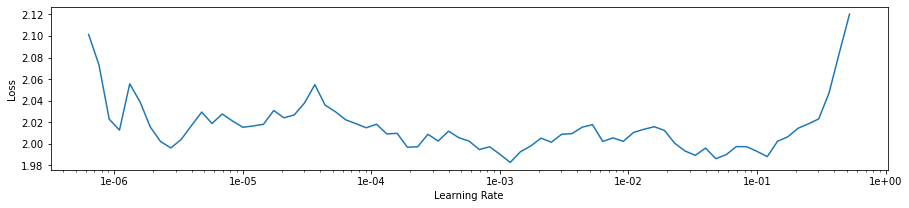

In [ ]:
#hide
learn = collab_learner(data, n_factors=50, y_range=[0,5.5])
learn.lr_find()
learn.recorder.plot(skip_end=15)

In [ ]:
learn.fit_one_cycle(1, 5e-6)

epoch,train_loss,valid_loss,time
0,2.054070,2.029182,00:20


In [ ]:
learn.summary()

EmbeddingDotBias
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [50]                 534,000    True      
______________________________________________________________________
Embedding            [50]                 129,150    True      
______________________________________________________________________
Embedding            [1]                  10,680     True      
______________________________________________________________________
Embedding            [1]                  2,583      True      
______________________________________________________________________

Total params: 676,413
Total trainable params: 676,413
Total non-trainable params: 0
Optimized with 'torch.optim.adam.Adam', betas=(0.9, 0.99)
Using true weight decay as discussed in https://www.fast.ai/2018/07/02/adam-weight-decay/ 
Loss function : FlattenedLoss
Callbacks functions applied 

In [ ]:
learn.fit(10, 1e-3)

epoch,train_loss,valid_loss,time
0,1.770657,1.751797,00:18
1,1.410351,1.528533,00:17
2,1.153979,1.399136,00:17
3,0.911953,1.326476,00:17
4,0.784223,1.279517,00:17
5,0.695546,1.248469,00:17
6,0.637151,1.230954,00:18
7,0.600011,1.216617,00:18
8,0.573309,1.209507,00:18
9,0.571132,1.204903,00:18
